# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files final project

**Date**: October 10th 2025

**Student Name**: Jaime Antonio Contreras Barragan

**Professor**: Pablo Camarillo Ramirez

# Create SparkSession

In [9]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final Project Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

#python3 review_producer.py kafka:9093 final-project

## PRODUCTOR

In [10]:
#docker exec -it 17d69a70801800 /opt/kafka/bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic final-project 
#Create the remote connection
#python3 review_producer.py kafka:9093 final-project

# Consumidor

## Create a data stream from a Kafka topic

In [11]:
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", " final-project") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## DATASET AND STREAM CREATION

In [12]:
from jaimodule.spark_utils import SparkUtils
from pyspark.sql.functions import year, month, day, from_json, col, to_date
from pyspark.sql.types import StructField, StringType
review_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

path = "/opt/spark/work-dir/data/logs"

#schema para importar la info
schema = SparkUtils.generate_schema([
    ("review_id","int"),
    ("customer_name","string"),
    ("age", "int"),
    ("brand", "string"),
    ("model", "string"),
    ("price_usd", "float"),
    ("price_local", "string"),
    ("currency", "string"),
    ("exchange_rate_to_usd", "float"),
    ("rating", "int"),
    ("review_text", "string"),
    ("sentiment", "string"),
    ("country", "string"),
    ("language", "string"),
    ("review_date", "date"),
    ("verified_purchase", "boolean"),
    ("battery_life_rating", "int"),
    ("camera_rating", "int"),
    ("performance_rating", "int"),
    ("design_rating", "int"),
    ("display_rating", "int"),
    ("review_length", "int"),
    ("word_count", "int"),
    ("helpful_votes", "int"),
    ("source", "string")
])

review_extracted_df = review_df.withColumn("review", from_json(review_df.value_str, schema))
review_extracted_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- review: struct (nullable = true)
 |    |-- review_id: integer (nullable = true)
 |    |-- customer_name: string (nullable = true)
 |    |-- age: integer (nullable = true)
 |    |-- brand: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- price_usd: float (nullable = true)
 |    |-- price_local: string (nullable = true)
 |    |-- currency: string (nullable = true)
 |    |-- exchange_rate_to_usd: float (nullable = true)
 |    |-- rating: integer (nullable = true)
 |    |-- review_text: string (nullable = true)
 |    |-- sentiment: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- review_date: date (nullable = true)
 |    |-- verified_purchase: boolean (nullable = true)
 |    |-- battery_life_rating: integer (nullable = true)
 |    |-- camera_rating: integer (nullable = true)
 |    |-- performance_rating: integer (nullable = true)
 |    |-

## Transformations

In [13]:
from pyspark.sql.functions import col, when, round
#Dejamos todos los que sean verified purchase
reviews_verified_df = review_extracted_df.filter(
    (col("review.verified_purchase") == True)
)

review_trans_df = reviews_verified_df \
    .withColumn("avg_all_ratings", round(
        (col("review.battery_life_rating") +
         col("review.camera_rating") +
         col("review.performance_rating") +
         col("review.design_rating") +
         col("review.display_rating")) / 5.0, 2
    )) \
    .withColumn(
        "age_category",
        when(col("review.age") < 26, "adolescent")
        .when(col("review.age").between(26, 35), "adult")
        .when(col("review.age").between(36, 45), "senior")
        .when(col("review.age") > 45, "veteran")
    ) \
    .withColumn(
        "country", col("review.country")
    )

#SE EXCLUYE DATE PORQUE todas las reviews del DF original son de el lapso de 1 año 2024-2025 y en si mi producer es 

flattened_df = review_trans_df.select(
    col("review.review_id"),
    col("review.customer_name"),
    col("review.age"),
    col("review.brand"),
    col("review.model"),
    col("review.price_usd"),
    col("review.price_local"),
    col("review.currency"),
    col("review.exchange_rate_to_usd"),
    col("review.rating"),
    col("review.review_text"),
    col("review.sentiment"),
    col("review.country"),
    col("review.language"),
    col("review.verified_purchase"),
    col("review.battery_life_rating"),
    col("review.camera_rating"),
    col("review.performance_rating"),
    col("review.design_rating"),
    col("review.display_rating"),
    col("review.review_length"),
    col("review.word_count"),
    col("review.helpful_votes"),
    col("review.source"),
    col("age_category"),
    col("avg_all_ratings")
)


flattened_df.printSchema()
# Son las mismas categorias, los nombres son asi para poder acomodarlos de manera alfabetica.


root
 |-- review_id: integer (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- price_usd: float (nullable = true)
 |-- price_local: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- exchange_rate_to_usd: float (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- country: string (nullable = true)
 |-- language: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- battery_life_rating: integer (nullable = true)
 |-- camera_rating: integer (nullable = true)
 |-- performance_rating: integer (nullable = true)
 |-- design_rating: integer (nullable = true)
 |-- display_rating: integer (nullable = true)
 |-- review_length: integer (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- helpful_votes: integer (nullable = t

## Persistence DATA

In [15]:
query_files = flattened_df.writeStream \
                .trigger(processingTime="10 seconds") \
                .partitionBy("country") \
                .format("csv") \
                .option("header", "true") \
                .option("path", "/opt/spark/work-dir/data/mobile_reviews_output/") \
                .option("checkpointLocation", "/opt/spark/work-dir/mobile_reviews_checkpoint") \
                .start()

#query_files.awaitTermination() # Wait 60 seconds before closing the stream


25/11/17 19:14:32 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/17 19:15:55 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000} milliseconds, but spent 15967 milliseconds
                                                                                

In [16]:
query_files.stop()

25/11/17 19:16:09 WARN DAGScheduler: Failed to cancel job group 11c86d41-8dcf-46bb-80f7-ad509ce8e076. Cannot find active jobs for it.
25/11/17 19:16:09 WARN DAGScheduler: Failed to cancel job group 11c86d41-8dcf-46bb-80f7-ad509ce8e076. Cannot find active jobs for it.


## POWER BI
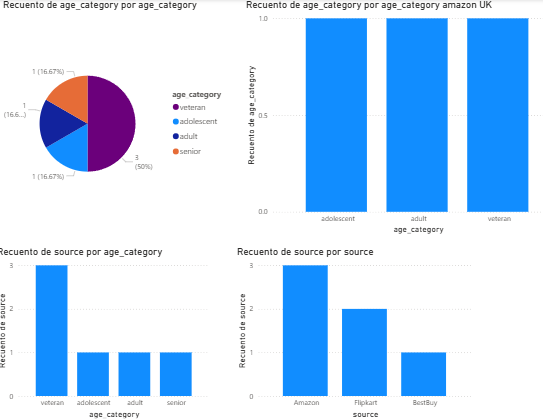

In [17]:
sc.stop

<bound method SparkContext.stop of <SparkContext master=spark://spark-master:7077 appName=Final Project Structured Streaming (files)>>